# `OceInterp` interpolation in the ECCO global state estimate.

Extract temperature/salinity profiles at specified longitudes, latitudes, and times. This process mimics hydrographic stations from in-situ measurements (like a ship CTD station, or Argo float profile).

This notebook uses [Oceanspy](https://oceanspy.readthedocs.io/en/latest/) and demonstrates the interface to the Poseidon-viewer on SciServer.

Author: Tom Haine & Wenrui Jiang, Jun '23

In [1]:
import seaduck as sd
import oceanspy as ospy

import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = 12, 8

```{admonition} Access ECCO
The global MITgcm run is the ECCO state estimate [(Forget et al, 2015)](https://gmd.copernicus.org/articles/8/3071/2015/) (from the Oceanography container). The simulation output can be opened using the [OceanSpy](https://github.com/hainegroup/oceanspyhttps://github.com/hainegroup/oceanspy) package using the [`from_catalog`](https://oceanspy.readthedocs.io/en/latest/generated/oceanspy.open_oceandataset.from_catalog.html#oceanspy.open_oceandataset.from_catalog) method. 

`ecco = ospy.open_oceandataset.from_catalog("ECCO")`

Click [here](https://dev-poseidon-ocean.pantheonsite.io/products/datasets/) for a full list of the dataset hosted and [here](https://oceanspy.readthedocs.io/en/latest/datasets.html#igpwinterhttps://oceanspy.readthedocs.io/en/latest/datasets.html#igpwinter) to find out more.
```

In [2]:
od = ospy.open_oceandataset.from_catalog("ECCO")

od._ds = od._ds.drop_vars({"k", "k_u", "k_p1", "k_l"})
co_list = [var for var in od._ds.variables if "time" not in od._ds[var].dims]
od._ds = od._ds.set_coords(co_list)

od._ds = od._ds.drop_vars("time_bnds")
od._ds["Temp"] = od._ds["THETA"]
od._ds["S"] = od._ds["SALT"]
this_time = "1992-03-16T12:00:00.000000000"
# Select time of interest.
# This is cut and pasted (with editing to convert format) from Poseidon-viewer,
# but in future should be returned in the JSON object.

varList = ["Temp", "S"]  # Select variables of interest.
Nvars = len(varList)
od._ds = od._ds.drop_vars([var for var in od._ds.data_vars if var not in varList])

Opening ECCO.
ECCO v4r4 3D dataset, ocean simulations on LLC90 grid (monthly mean output)


Define coordinates for interpolation from the Poseidon-viewer (or enter them manually):

In [3]:
ps = [
    {"type": "Point", "coordinates": [-57.710530333876235, 33.062070736515295]},
    {"type": "Point", "coordinates": [-89.55599488497559, 25.453020491528747]},
    {"type": "Point", "coordinates": [-74.70605786848537, 13.952759739624767]},
    {"type": "Point", "coordinates": [-59.06355926811892, 21.999755420813273]},
    {"type": "Point", "coordinates": [-41.69588507736159, 22.43955659234939]},
    {"type": "Point", "coordinates": [-45.113026771172656, 14.563543828761837]},
    {"type": "Point", "coordinates": [-26.081872200732885, 6.414099524482438]},
    {"type": "Point", "coordinates": [-17.396102656758963, -4.381322875209875]},
    {"type": "Point", "coordinates": [-26.702603318403906, -7.125636489486197]},
    {"type": "Point", "coordinates": [-32.51011235240231, -22.847802807885373]},
]
lons, lats = ospy.utils.viewer_to_range(ps)
Nstations = len(lons)

extracting Point


## `seaduck.OceInterp` interpolates the temperature and salinity to the specified coordinates.

This process makes synthetic hydrographic profiles from ECCO. Compute the potential density anomaly from the T/S data too.

In [4]:
tub = sd.OceData(od._ds)
times = sd.utils.convert_time(this_time)
Ntimes = times.size

depths = tub.Z.ravel()
Ndepths = len(depths)

sd_lons, sd_times, sd_depths = np.meshgrid(lons, times, depths, indexing="ij")
sd_lats, _, _ = np.meshgrid(lats, times, depths, indexing="ij")
sd_lons = np.ravel(sd_lons)
sd_lats = np.ravel(sd_lats)
sd_times = np.ravel(sd_times)
sd_depths = np.ravel(sd_depths)

[sd_Temp, sd_S] = np.array(
    sd.OceInterp(tub, varList, sd_lons, sd_lats, sd_depths, sd_times)
)
sd_depths2 = sd_depths.reshape(Nstations, Ntimes, Ndepths).squeeze()
sd_S = sd_S.reshape(Nstations, Ntimes, Ndepths).squeeze()
sd_Temp = sd_Temp.reshape(Nstations, Ntimes, Ndepths).squeeze()

sd_sigma0 = ospy.utils.densjmd95(sd_S, sd_Temp, 0) - 1000.0

## Plot station locations:

Cutting out the oceandataset.
faces in the cutout [1, 2, 10, 11]


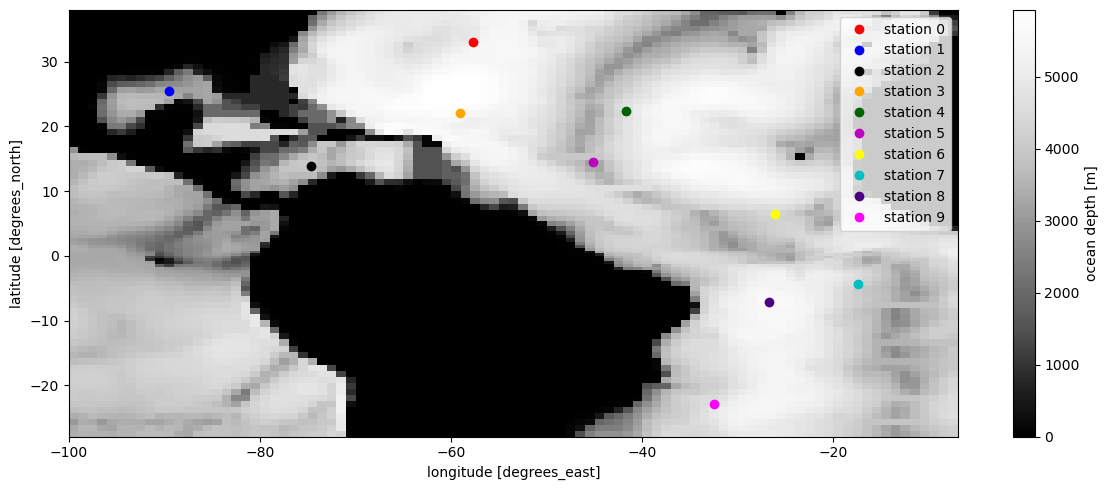

In [5]:
cut_od = od.subsample.cutout(
    XRange=[min(lons) - 10, max(lons) + 10], YRange=[min(lats) - 5, max(lats) + 5]
)
fig = plt.figure(figsize=(12, 5))
ax = cut_od.plot.horizontal_section(varName="Depth", cmap="Greys_r")
colors = [
    "r",
    "b",
    "k",
    "orange",
    "darkgreen",
    "m",
    "yellow",
    "c",
    "indigo",
    "magenta",
    "green",
]
legestations_ds = np.arange(Nstations)
for i in range(Nstations):
    plt.plot(
        lons[i],
        lats[i],
        "o",
        color=colors[i],
        label="station " + str(legestations_ds[i]),
    )
plt.legend()
plt.show()

## Plot vertical T/S station profiles:

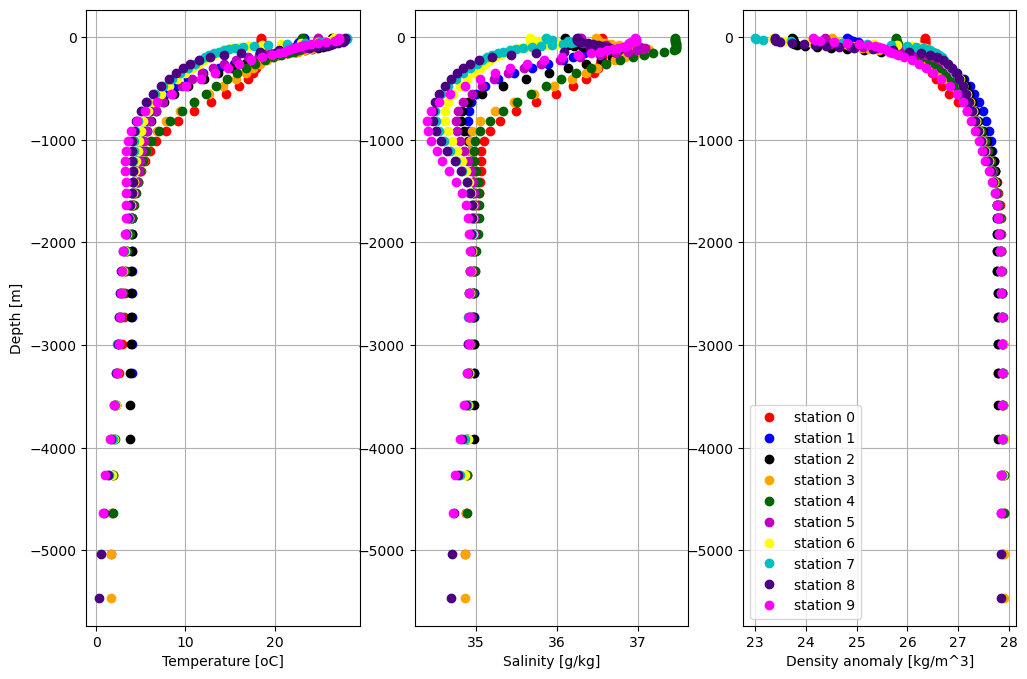

In [6]:
for i in range(Nstations):
    plt.subplot(1, 3, 1)
    plt.plot(
        sd_Temp[i, :],
        depths,
        "o",
        color=colors[i],
        label="station " + str(legestations_ds[i]),
    )
    plt.xlabel("Temperature [oC]")
    plt.ylabel("Depth [m]")
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.plot(
        sd_S[i, :],
        depths,
        "o",
        color=colors[i],
        label="station " + str(legestations_ds[i]),
    )
    plt.xlabel("Salinity [g/kg]")
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(
        sd_sigma0[i, :],
        depths,
        "o",
        color=colors[i],
        label="station " + str(legestations_ds[i]),
    )
    plt.xlabel("Density anomaly [kg/m^3]")
    plt.grid()

plt.subplot(1, 3, 1)
plt.xlabel("Temperature [oC]")
plt.ylabel("Depth [m]")
plt.grid()

plt.subplot(1, 3, 2)
plt.xlabel("Salinity [g/kg]")
plt.grid()

plt.subplot(1, 3, 3)
plt.xlabel("Density anomaly [kg/m^3]")
plt.grid()
plt.legend()

plt.show()

## Plot T/S diagram.

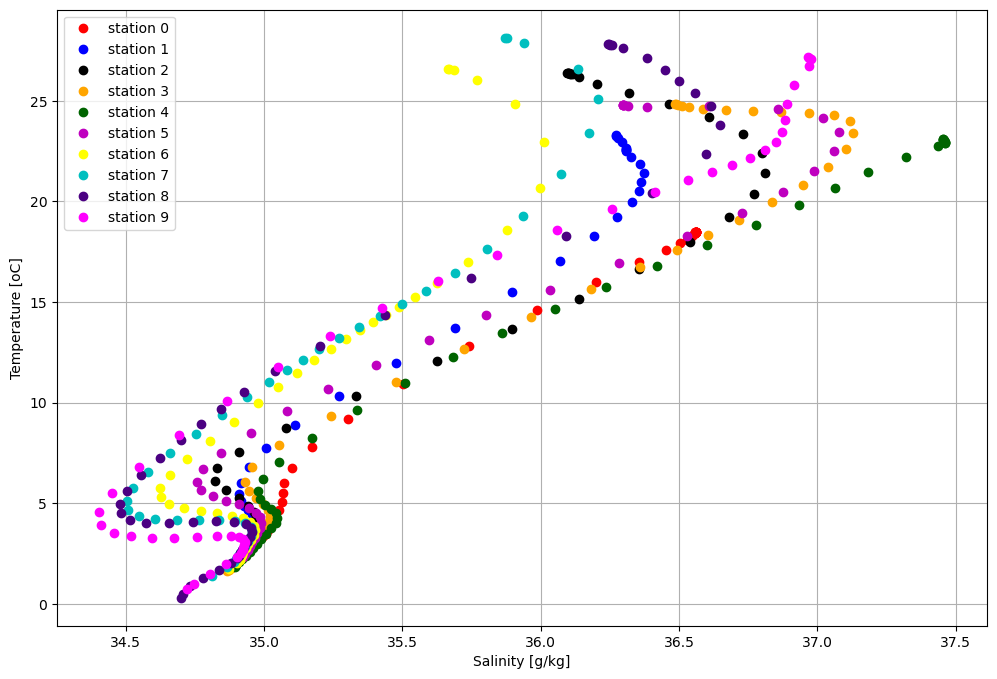

In [7]:
for i in range(Nstations):
    plt.plot(
        sd_S[i, :],
        sd_Temp[i, :],
        "o",
        color=colors[i],
        label="station " + str(legestations_ds[i]),
    )
plt.xlabel("Salinity [g/kg]")
plt.ylabel("Temperature [oC]")
plt.legend()
plt.grid()
plt.show()